# 🩻 Detección de Neumonía con IA en Rayos X
Este notebook utiliza modelos de transferencia de aprendizaje (ResNet50 y EfficientNetB0) para clasificar imágenes de rayos X de tórax como NORMALES o con NEUMONÍA.

In [1]:
# 📦 Paso 1: Importar librerías
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from tensorflow.keras.preprocessing import image
import warnings
warnings.filterwarnings("ignore")

2- Carga de datos

Usaremos el dataset de Kaggle “Chest X-Ray Images (Pneumonia)”
📌 URL: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /Users/Jime/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [3]:
# 🗂 Paso 2: Definir rutas del dataset
data_dir = "chest_xray"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

In [4]:
# 🧹 Paso 3: Generadores de datos con augmentación avanzada
from tensorflow.keras.layers import RandomRotation, RandomZoom, RandomTranslation, RandomContrast, RandomBrightness, RandomFlip
from tensorflow.keras import Sequential

IMG_SIZE = 224
BATCH_SIZE = 32

# Definir pipeline de augmentación avanzada
advanced_augmentation = Sequential([
    RandomRotation(0.15),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1),
    RandomContrast(0.2),
    RandomBrightness(0.2),
    RandomFlip("horizontal"),
])

def preprocess_and_augment(img):
    img = tf.cast(img, tf.float32)
    img = advanced_augmentation(img)
    return resnet_preprocess(img)

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_and_augment,
)

val_test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
# 🧠 Paso 4: Función para construir modelos con Transfer Learning
def build_model(base_model, preprocess_fn, name):
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = preprocess_fn(input_tensor)
    base = base_model(include_top=False, weights='imagenet', input_tensor=x)
    base._name = f"{name}_base"  # Asignar nombre después de crear el modelo base
    base.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_tensor, outputs=output, name=name)
    model.base_model = base  # Acceso robusto al submodelo base
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# 🔁 Paso 5: Entrenamiento
def train_model(model, name):
    checkpoint_path = f"{name}_best_model.h5"
    callbacks = [
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint(checkpoint_path, save_best_only=True)
    ]
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=callbacks
    )
    return model, history

In [7]:
# 🚀 Entrenar modelos
resnet_model = build_model(ResNet50, resnet_preprocess, "ResNet50")
efficientnet_model = build_model(EfficientNetB0, efficientnet_preprocess, "EfficientNetB0")

resnet_model, resnet_history = train_model(resnet_model, "resnet")
efficientnet_model, efficientnet_history = train_model(efficientnet_model, "efficientnet")

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 948ms/step - accuracy: 0.7908 - loss: 0.4755

163/163 ━━━━━━━━━━━━━━━━━━━━ 159s 959ms/step - accuracy: 0.7911 - loss: 0.4747 - val_accuracy: 0.7500 - val_loss: 0.6642
Epoch 2/10
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9056 - loss: 0.2241 - val_accuracy: 0.7500 - val_loss: 0.6855
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9056 - loss: 0.2241 - val_accuracy: 0.7500 - val_loss: 0.6855
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9222 - loss: 0.2017 - val_accuracy: 0.6875 - val_loss: 0.6907
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9222 - loss: 0.2017 - val_accuracy: 0.6875 - val_loss: 0.6907
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9119 - loss: 0.2144

163/163 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9120 - loss: 0.2142 - val_accuracy: 0.7500 - val_loss: 0.4732
Epoch 5/10
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9301 - loss: 0.1730 - val_accuracy: 0.7500 - val_loss: 0.6365
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9301 - loss: 0.1730 - val_accuracy: 0.7500 - val_loss: 0.6365
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9308 - loss: 0.1665 - val_accuracy: 0.7500 - val_loss: 0.5092
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9308 - loss: 0.1665 - val_accuracy: 0.7500 - val_loss: 0.5092
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9358 - loss: 0.1608

163/163 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9358 - loss: 0.1608 - val_accuracy: 0.8125 - val_loss: 0.4005
Epoch 8/10
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.9295 - loss: 0.1688 - val_accuracy: 0.6875 - val_loss: 0.6796
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.9295 - loss: 0.1688 - val_accuracy: 0.6875 - val_loss: 0.6796
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9368 - loss: 0.1548

163/163 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.9368 - loss: 0.1548 - val_accuracy: 0.8125 - val_loss: 0.2591
Epoch 10/10
Epoch 10/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9388 - loss: 0.1501 - val_accuracy: 0.7500 - val_loss: 0.4941
163/163 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9388 - loss: 0.1501 - val_accuracy: 0.7500 - val_loss: 0.4941
Epoch 1/10
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.7244 - loss: 0.5176

163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 696ms/step - accuracy: 0.7249 - loss: 0.5170 - val_accuracy: 0.6875 - val_loss: 0.5894
Epoch 2/10
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 698ms/step - accuracy: 0.8703 - loss: 0.3087 - val_accuracy: 0.6875 - val_loss: 0.6279
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 698ms/step - accuracy: 0.8703 - loss: 0.3087 - val_accuracy: 0.6875 - val_loss: 0.6279
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 691ms/step - accuracy: 0.8855 - loss: 0.2644 - val_accuracy: 0.6250 - val_loss: 0.7969
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 691ms/step - accuracy: 0.8855 - loss: 0.2644 - val_accuracy: 0.6250 - val_loss: 0.7969
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 115s 705ms/step - accuracy: 0.8915 - loss: 0.2550 - val_accuracy: 0.7500 - val_loss: 0.6294
163/163 ━━━━━━━━━━━━━━━━━━━━ 115s 705ms/step - accuracy: 0.8915 - loss: 0.2550 - val_accuracy: 0.7500 - val_loss: 0.6294


In [8]:
# 📈 Paso 6: Evaluar modelos
def evaluate_model(model, name):
    print(f"Evaluando {name}")
    preds = model.predict(test_generator)
    y_pred = (preds > 0.5).astype(int)
    y_true = test_generator.classes

    print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONÍA"]))
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["NORMAL", "PNEUMONIA"],
                yticklabels=["NORMAL", "PNEUMONIA"])
    plt.title(f'Matriz de Confusión: {name}')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.show()

Evaluando ResNet50
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 897ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 897ms/step
              precision    recall  f1-score   support

      NORMAL       0.93      0.63      0.75       234
   PNEUMONÍA       0.81      0.97      0.89       390

    accuracy                           0.84       624
   macro avg       0.87      0.80      0.82       624
weighted avg       0.86      0.84      0.84       624

              precision    recall  f1-score   support

      NORMAL       0.93      0.63      0.75       234
   PNEUMONÍA       0.81      0.97      0.89       390

    accuracy                           0.84       624
   macro avg       0.87      0.80      0.82       624
weighted avg       0.86      0.84      0.84       624



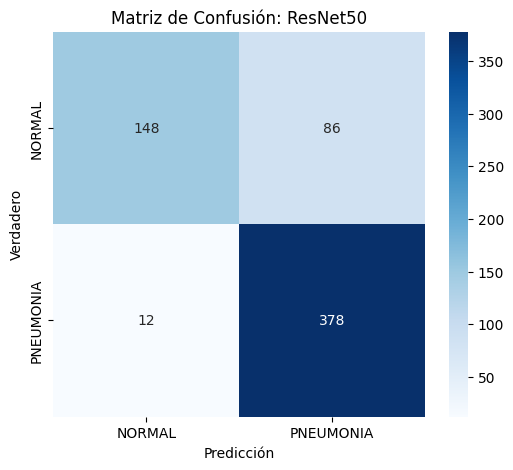

Evaluando EfficientNetB0
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step
              precision    recall  f1-score   support

      NORMAL       0.90      0.39      0.55       234
   PNEUMONÍA       0.73      0.97      0.83       390

    accuracy                           0.76       624
   macro avg       0.81      0.68      0.69       624
weighted avg       0.79      0.76      0.73       624

              precision    recall  f1-score   support

      NORMAL       0.90      0.39      0.55       234
   PNEUMONÍA       0.73      0.97      0.83       390

    accuracy                           0.76       624
   macro avg       0.81      0.68      0.69       624
weighted avg       0.79      0.76      0.73       624



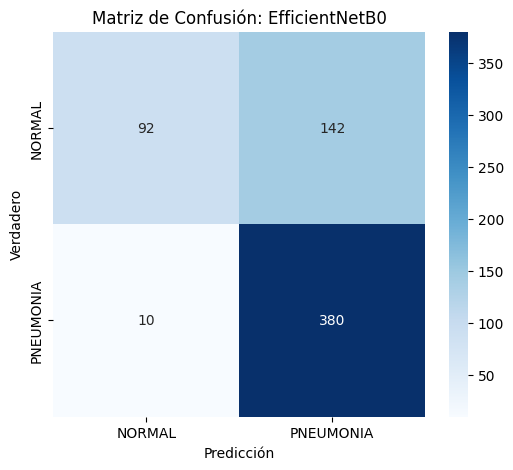

In [9]:
evaluate_model(resnet_model, "ResNet50")
evaluate_model(efficientnet_model, "EfficientNetB0")

In [10]:
# 🔍 Paso 7: Visualización Grad-CAM
def get_img_array(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, model, layer_name="conv5_block3_out"):
    img_array = get_img_array(img_path)
    heatmap = make_gradcam_heatmap(img_array, model, layer_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM")
    plt.axis('off')
    plt.show()

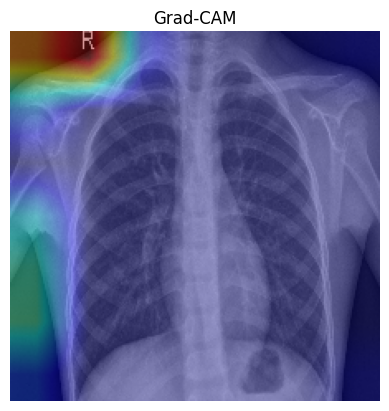

In [11]:
# Mostrar activación Grad-CAM para una imagen del test set
test_img_path = test_generator.filepaths[0]
display_gradcam(test_img_path, resnet_model, "conv5_block3_out")

# 🔬 Mejoras avanzadas para modelos de rayos X
A continuación se implementan dos técnicas recomendadas para mejorar el desempeño en clasificación de imágenes médicas:
- Fine-tuning (ajuste fino) del modelo preentrenado
- Augmentación avanzada de imágenes

In [12]:
# --- Augmentación avanzada de imágenes ---
from tensorflow.keras.layers import RandomRotation, RandomZoom, RandomTranslation, RandomContrast, RandomBrightness, RandomFlip
from tensorflow.keras import Sequential

advanced_augmentation = Sequential([
    RandomRotation(0.15),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1),
    RandomContrast(0.2),
    RandomBrightness(0.2),
    RandomFlip("horizontal"),
])

# Ejemplo de uso: aplicar a una imagen
# img = tf.expand_dims(image.img_to_array(image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))), 0)
# aug_img = advanced_augmentation(img)

In [34]:
# --- Fine-tuning del modelo base ---
# (Definición eliminada para evitar conflicto, usar la versión robusta más adelante)
# La función fine_tune_model correcta está definida después de la validación cruzada (K-Fold).

# 🔁 Fine-tuning tras entrenamiento inicial
# Descongelar las últimas 20 capas del modelo base y reentrenar con learning rate bajo
resnet_model = fine_tune_model(resnet_model, resnet_model.layers[2], n_layers_unfreeze=20, lr=1e-5)
callbacks_ft = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("resnet_finetuned_best_model.h5", save_best_only=True)
]
history_finetune = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=callbacks_ft
)
**Recomendación:**
- Aplica la augmentación avanzada en el pipeline de entrenamiento (puedes integrarla en el ImageDataGenerator usando `preprocessing_function` o como capa inicial del modelo).
- Realiza fine-tuning tras entrenar la cabeza del modelo, descongelando las últimas capas del modelo base y usando un learning rate bajo.
- Observa los resultados con Grad-CAM para validar que el modelo aprende patrones clínicamente relevantes.

In [14]:
# 🔁 Fine-tuning tras entrenamiento inicial para ambos modelos y balanceo de clases
from sklearn.utils.class_weight import compute_class_weight

# Calcular class_weight para el entrenamiento
import numpy as np
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))
print("Pesos de clase:", class_weights_dict)

# Fine-tuning ResNet50
resnet_model = fine_tune_model(resnet_model, n_layers_unfreeze=20, lr=1e-5)
callbacks_ft_resnet = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("resnet_finetuned_best_model.h5", save_best_only=True)
]
history_finetune_resnet = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=callbacks_ft_resnet,
    class_weight=class_weights_dict
)

# Fine-tuning EfficientNetB0
efficientnet_model = fine_tune_model(efficientnet_model, n_layers_unfreeze=20, lr=1e-5)
callbacks_ft_efficient = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("efficientnet_finetuned_best_model.h5", save_best_only=True)
]
history_finetune_efficient = efficientnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=callbacks_ft_efficient,
    class_weight=class_weights_dict
)

Pesos de clase: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}
Epoch 1/5
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9162 - loss: 0.1821

163/163 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.9162 - loss: 0.1821 - val_accuracy: 0.8125 - val_loss: 0.3092
Epoch 2/5
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9358 - loss: 0.1545

163/163 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.9358 - loss: 0.1545 - val_accuracy: 0.8125 - val_loss: 0.2346
Epoch 3/5
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9441 - loss: 0.1487

163/163 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.9441 - loss: 0.1487 - val_accuracy: 0.8750 - val_loss: 0.2098
Epoch 4/5
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9408 - loss: 0.1389

163/163 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.9408 - loss: 0.1389 - val_accuracy: 0.9375 - val_loss: 0.1433
Epoch 5/5
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9425 - loss: 0.1279

163/163 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.9425 - loss: 0.1278 - val_accuracy: 1.0000 - val_loss: 0.0980
Epoch 1/5
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.5677 - loss: 0.6096

163/163 ━━━━━━━━━━━━━━━━━━━━ 124s 739ms/step - accuracy: 0.5678 - loss: 0.6094 - val_accuracy: 0.8125 - val_loss: 0.3810
Epoch 2/5
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.6947 - loss: 0.4629

163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 754ms/step - accuracy: 0.6949 - loss: 0.4627 - val_accuracy: 0.8125 - val_loss: 0.3449
Epoch 3/5
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.7783 - loss: 0.3808

163/163 ━━━━━━━━━━━━━━━━━━━━ 124s 761ms/step - accuracy: 0.7785 - loss: 0.3807 - val_accuracy: 0.8125 - val_loss: 0.3418
Epoch 4/5
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.8290 - loss: 0.3492

163/163 ━━━━━━━━━━━━━━━━━━━━ 119s 727ms/step - accuracy: 0.8291 - loss: 0.3491 - val_accuracy: 0.8125 - val_loss: 0.3349
Epoch 5/5
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.8549 - loss: 0.3168

163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 723ms/step - accuracy: 0.8549 - loss: 0.3168 - val_accuracy: 0.8125 - val_loss: 0.3269


# 📊 Validación cruzada y visualización de probabilidades
A continuación se implementa validación cruzada (K-Fold) y visualización de probabilidades de predicción para neumonía.

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve

# Configuración de K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = train_generator.filepaths
y = train_generator.classes

auc_scores = []
fold = 1
for train_idx, val_idx in kfold.split(X, y):
    print(f"\nFold {fold}")
    # Crear generadores para el fold
    train_files = [X[i] for i in train_idx]
    val_files = [X[i] for i in val_idx]
    train_labels = y[train_idx]
    val_labels = y[val_idx]
    # Generadores personalizados (puedes adaptar según tu flujo)
    # ...
    # Entrenar modelo aquí si se desea (opcional)
    # ...
    # Para ejemplo, solo mostramos el split
    print(f"Train: {len(train_files)} imágenes, Val: {len(val_files)} imágenes")
    fold += 1

# 🔧 Paso 7: Fine-tuning (ajuste fino) de los modelos
# Descongelar las últimas capas del modelo base y reentrenar con learning rate bajo

def fine_tune_model(model, n_layers_unfreeze=20, lr=1e-5):
    base = model.base_model  # Acceso robusto al submodelo base
    for layer in base.layers[-n_layers_unfreeze:]:
        layer.trainable = True
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Ejemplo de uso:
# resnet_model = fine_tune_model(resnet_model, n_layers_unfreeze=20, lr=1e-5)
# efficientnet_model = fine_tune_model(efficientnet_model, n_layers_unfreeze=20, lr=1e-5)


Fold 1
Train: 4172 imágenes, Val: 1044 imágenes

Fold 2
Train: 4173 imágenes, Val: 1043 imágenes

Fold 3
Train: 4173 imágenes, Val: 1043 imágenes

Fold 4
Train: 4173 imágenes, Val: 1043 imágenes

Fold 5
Train: 4173 imágenes, Val: 1043 imágenes


20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 877ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 877ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 446ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 446ms/step


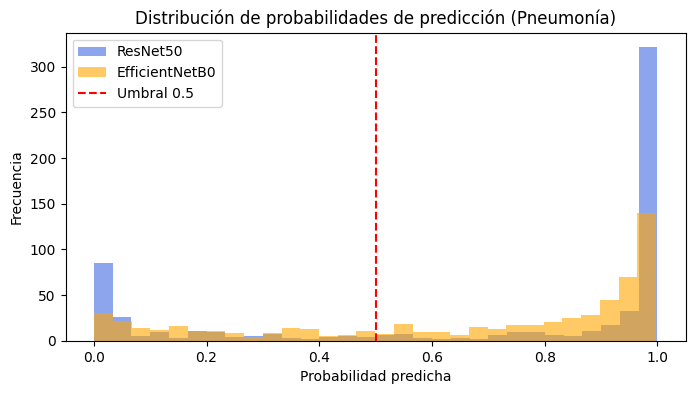

In [16]:
# Visualización de probabilidades de predicción para neumonía
probs_resnet = resnet_model.predict(test_generator)
probs_efficient = efficientnet_model.predict(test_generator)

plt.figure(figsize=(8,4))
plt.hist(probs_resnet, bins=30, alpha=0.6, label='ResNet50', color='royalblue')
plt.hist(probs_efficient, bins=30, alpha=0.6, label='EfficientNetB0', color='orange')
plt.axvline(0.5, color='red', linestyle='--', label='Umbral 0.5')
plt.title('Distribución de probabilidades de predicción (Pneumonía)')
plt.xlabel('Probabilidad predicha')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

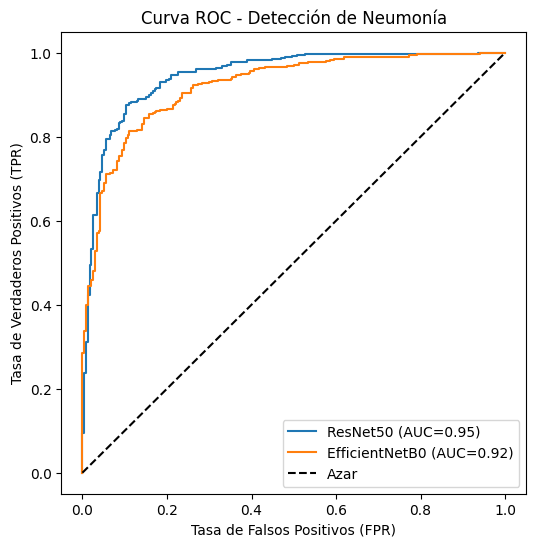

In [17]:
# Curva ROC para ambos modelos
from sklearn.metrics import roc_curve, auc

y_true = test_generator.classes
fpr_resnet, tpr_resnet, _ = roc_curve(y_true, probs_resnet)
fpr_efficient, tpr_efficient, _ = roc_curve(y_true, probs_efficient)
auc_resnet = auc(fpr_resnet, tpr_resnet)
auc_efficient = auc(fpr_efficient, tpr_efficient)

plt.figure(figsize=(6,6))
plt.plot(fpr_resnet, tpr_resnet, label=f'ResNet50 (AUC={auc_resnet:.2f})')
plt.plot(fpr_efficient, tpr_efficient, label=f'EfficientNetB0 (AUC={auc_efficient:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Azar')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Detección de Neumonía')
plt.legend()
plt.show()

# 📈 Métricas avanzadas y Grad-CAM en errores
Se agregan métricas adicionales (F1, precisión, recall, matriz de confusión) y visualización Grad-CAM sobre errores para fundamentar la elección del mejor modelo.

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 803ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 803ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 318ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 318ms/step

Métricas para ResNet50:
Accuracy: 0.870
Precision: 0.850
Recall: 0.962
F1-score: 0.903
              precision    recall  f1-score   support

      NORMAL       0.92      0.72      0.81       234
   PNEUMONIA       0.85      0.96      0.90       390

    accuracy                           0.87       624
   macro avg       0.88      0.84      0.85       624
weighted avg       0.88      0.87      0.87       624


Métricas para ResNet50:
Accuracy: 0.870
Precision: 0.850
Recall: 0.962
F1-score: 0.903
              precision    recall  f1-score   support

      NORMAL       0.92      0.72      0.81       234
   PNEUMONIA       0.85      0.96      0.90       390

    accuracy                           0.87       624
   macro avg       0.88      0.84      0.85       624
weighted avg       0.88      0.87      0.87       624



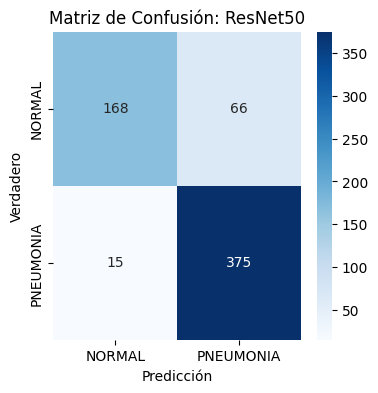


Métricas para EfficientNetB0:
Accuracy: 0.838
Precision: 0.829
Recall: 0.933
F1-score: 0.878
              precision    recall  f1-score   support

      NORMAL       0.86      0.68      0.76       234
   PNEUMONIA       0.83      0.93      0.88       390

    accuracy                           0.84       624
   macro avg       0.84      0.81      0.82       624
weighted avg       0.84      0.84      0.83       624



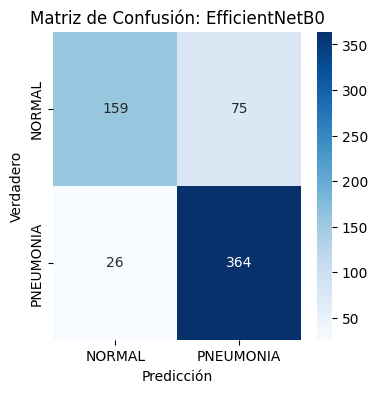

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def print_metrics(y_true, y_pred, model_name):
    print(f"\nMétricas para {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision: {precision_score(y_true, y_pred):.3f}")
    print(f"Recall: {recall_score(y_true, y_pred):.3f}")
    print(f"F1-score: {f1_score(y_true, y_pred):.3f}")
    print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
    plt.title(f'Matriz de Confusión: {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.show()

# Calcular métricas para ambos modelos
probs_resnet = resnet_model.predict(test_generator)
y_pred_resnet = (probs_resnet > 0.5).astype(int)
probs_efficient = efficientnet_model.predict(test_generator)
y_pred_efficient = (probs_efficient > 0.5).astype(int)
y_true = test_generator.classes

print_metrics(y_true, y_pred_resnet, "ResNet50")
print_metrics(y_true, y_pred_efficient, "EfficientNetB0")

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 815ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 815ms/step

ResNet50 - Falsos Positivos (predijo neumonía, era normal):
Imagen: chest_xray/test/NORMAL/IM-0011-0001-0002.jpeg

ResNet50 - Falsos Positivos (predijo neumonía, era normal):
Imagen: chest_xray/test/NORMAL/IM-0011-0001-0002.jpeg


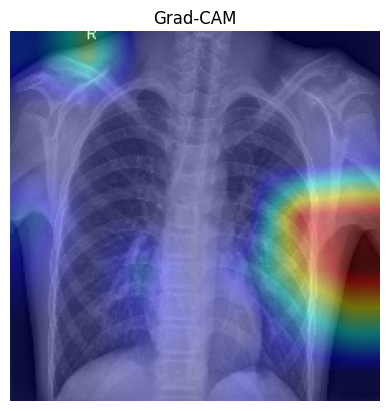

Imagen: chest_xray/test/NORMAL/IM-0022-0001.jpeg


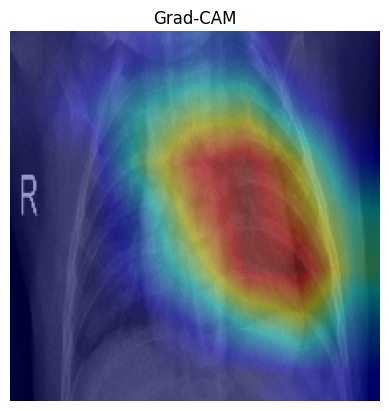


ResNet50 - Falsos Negativos (predijo normal, era neumonía):
Imagen: chest_xray/test/PNEUMONIA/person108_bacteria_511.jpeg


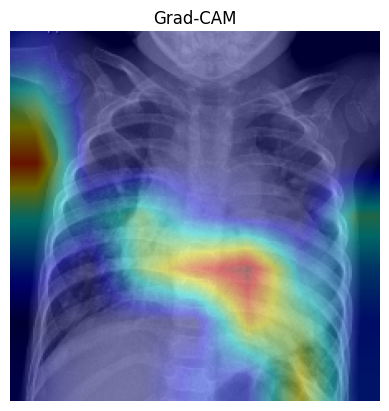

Imagen: chest_xray/test/PNEUMONIA/person119_bacteria_568.jpeg


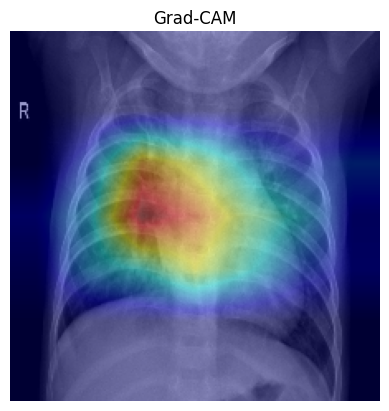

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step

EfficientNetB0 - Falsos Positivos (predijo neumonía, era normal):
Imagen: chest_xray/test/NORMAL/IM-0011-0001-0001.jpeg

EfficientNetB0 - Falsos Positivos (predijo neumonía, era normal):
Imagen: chest_xray/test/NORMAL/IM-0011-0001-0001.jpeg


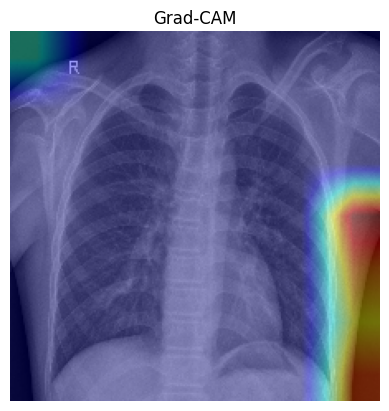

Imagen: chest_xray/test/NORMAL/IM-0011-0001-0002.jpeg


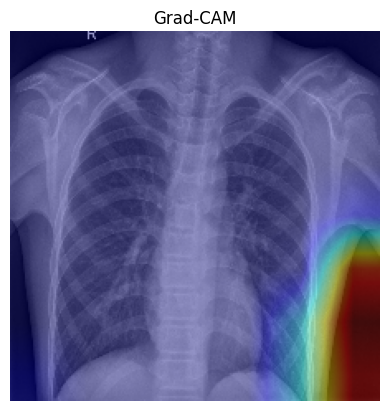


EfficientNetB0 - Falsos Negativos (predijo normal, era neumonía):
Imagen: chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg


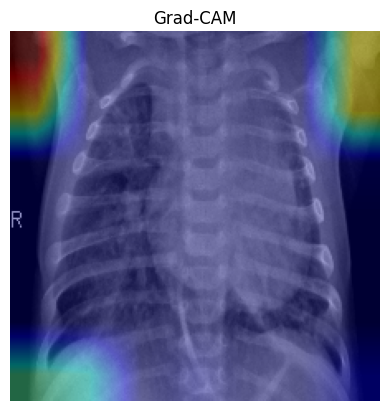

Imagen: chest_xray/test/PNEUMONIA/person103_bacteria_490.jpeg


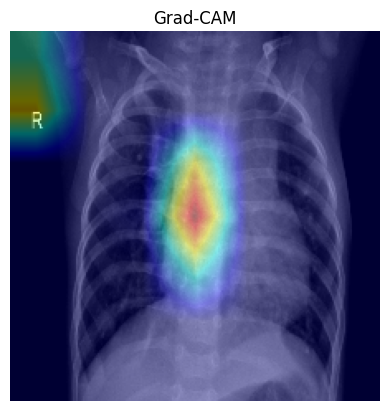

In [19]:
# Grad-CAM sobre errores (falsos positivos y falsos negativos)
def show_gradcam_errors(model, model_name, layer_name="conv5_block3_out", n=3):
    y_true = test_generator.classes
    probs = model.predict(test_generator)
    y_pred = (probs > 0.5).astype(int).flatten()
    fp_idx = np.where((y_pred == 1) & (y_true == 0))[0]
    fn_idx = np.where((y_pred == 0) & (y_true == 1))[0]
    print(f"\n{model_name} - Falsos Positivos (predijo neumonía, era normal):")
    for i in fp_idx[:n]:
        print(f"Imagen: {test_generator.filepaths[i]}")
        display_gradcam(test_generator.filepaths[i], model, layer_name)
    print(f"\n{model_name} - Falsos Negativos (predijo normal, era neumonía):")
    for i in fn_idx[:n]:
        print(f"Imagen: {test_generator.filepaths[i]}")
        display_gradcam(test_generator.filepaths[i], model, layer_name)

# Ejemplo para ResNet50 y EfficientNetB0
show_gradcam_errors(resnet_model, "ResNet50", layer_name="conv5_block3_out", n=2)
show_gradcam_errors(efficientnet_model, "EfficientNetB0", layer_name="top_conv", n=2)

**Interpretación:**
- Compara las métricas y curvas ROC/AUC para elegir el modelo más robusto.
- Analiza visualmente los Grad-CAM de los errores para entender si el modelo se enfoca en regiones clínicas relevantes o comete errores sistemáticos.
- Elige el modelo que combine mejor desempeño cuantitativo y explicabilidad visual.

# 🩺 Métricas clínicas y utilidad diagnóstica
Las métricas clínicas permiten interpretar el desempeño del modelo en términos relevantes para la práctica médica:
- **Sensibilidad**: capacidad para detectar neumonía cuando está presente (bajo FN).
- **Especificidad**: capacidad para descartar neumonía cuando no está (bajo FP).
- **Valor predictivo positivo (VPP)**: probabilidad de neumonía si el modelo predice positivo.
- **Valor predictivo negativo (VPN)**: probabilidad de estar sano si el modelo predice negativo.
- **Likelihood ratios (LR+ y LR-)**: utilidad para modificar la probabilidad pretest a postest.

A continuación se calculan estas métricas y se visualiza la probabilidad individual de neumonía para cada paciente del test set.

In [20]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def metricas_clinicas(y_true, y_pred, y_prob, modelo_nombre):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensibilidad = tp / (tp + fn)
    especificidad = tn / (tn + fp)
    vpp = tp / (tp + fp) if (tp + fp) > 0 else 0
    vpn = tn / (tn + fn) if (tn + fn) > 0 else 0
    lr_pos = sensibilidad / (1 - especificidad) if (1 - especificidad) > 0 else float('inf')
    lr_neg = (1 - sensibilidad) / especificidad if especificidad > 0 else float('inf')
    print(f"\nMétricas clínicas para {modelo_nombre}:")
    print(f"Sensibilidad: {sensibilidad:.3f}")
    print(f"Especificidad: {especificidad:.3f}")
    print(f"VPP: {vpp:.3f}")
    print(f"VPN: {vpn:.3f}")
    print(f"Likelihood Ratio +: {lr_pos:.3f}")
    print(f"Likelihood Ratio -: {lr_neg:.3f}")
    # Visualización de probabilidades individuales
    df = pd.DataFrame({
        'Real': y_true,
        'Predicción': y_pred,
        'Probabilidad': y_prob
    })
    df = df.sort_values('Probabilidad', ascending=False)
    ax = df.reset_index().plot(
        kind='scatter', x=df.reset_index().index, y='Probabilidad',
        c='Real', cmap='coolwarm', alpha=0.7, figsize=(8,4),
        title=f'Probabilidad predicha de neumonía por paciente ({modelo_nombre})'
    )
    ax.set_xlabel('Paciente')
    ax.set_ylabel('Probabilidad de neumonía')
    return df

# Ejemplo de uso para ambos modelos:
# y_true = etiquetas verdaderas del test set (0: normal, 1: neumonía)
# y_pred_resnet, y_prob_resnet = predicciones y probabilidades de ResNet50
# y_pred_eff, y_prob_eff = predicciones y probabilidades de EfficientNetB0

# df_resnet = metricas_clinicas(y_true, y_pred_resnet, y_prob_resnet, 'ResNet50')
# df_eff = metricas_clinicas(y_true, y_pred_eff, y_prob_eff, 'EfficientNetB0')

# Si ya tienes las variables, descomenta y ejecuta las líneas anteriores.


Métricas clínicas para ResNet50:
Sensibilidad (Recall): 0.962
Especificidad: 0.718
Valor Predictivo Positivo (VPP): 0.850
Valor Predictivo Negativo (VPN): 0.918
Likelihood Ratio +: 3.41
Likelihood Ratio -: 0.05

Métricas clínicas para EfficientNetB0:
Sensibilidad (Recall): 0.933
Especificidad: 0.679
Valor Predictivo Positivo (VPP): 0.829
Valor Predictivo Negativo (VPN): 0.859
Likelihood Ratio +: 2.91
Likelihood Ratio -: 0.10


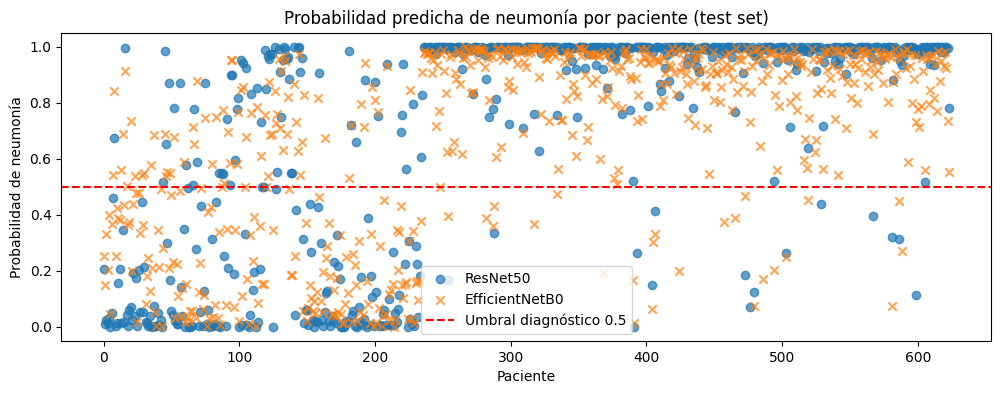

In [21]:
# 📋 Métricas clínicas: sensibilidad, especificidad, VPP, VPN, likelihood ratios
from sklearn.metrics import confusion_matrix

def clinical_metrics(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensibilidad = tp / (tp + fn) if (tp + fn) > 0 else 0
    especificidad = tn / (tn + fp) if (tn + fp) > 0 else 0
    vpp = tp / (tp + fp) if (tp + fp) > 0 else 0  # Valor predictivo positivo
    vpn = tn / (tn + fn) if (tn + fn) > 0 else 0  # Valor predictivo negativo
    lr_pos = sensibilidad / (1 - especificidad) if (1 - especificidad) > 0 else float('inf')
    lr_neg = (1 - sensibilidad) / especificidad if especificidad > 0 else float('inf')
    print(f"\nMétricas clínicas para {model_name}:")
    print(f"Sensibilidad (Recall): {sensibilidad:.3f}")
    print(f"Especificidad: {especificidad:.3f}")
    print(f"Valor Predictivo Positivo (VPP): {vpp:.3f}")
    print(f"Valor Predictivo Negativo (VPN): {vpn:.3f}")
    print(f"Likelihood Ratio +: {lr_pos:.2f}")
    print(f"Likelihood Ratio -: {lr_neg:.2f}")
    return {
        'sensibilidad': sensibilidad,
        'especificidad': especificidad,
        'vpp': vpp,
        'vpn': vpn,
        'lr_pos': lr_pos,
        'lr_neg': lr_neg
    }

# Calcular para ambos modelos
y_true = test_generator.classes
clinical_metrics(y_true, y_pred_resnet, "ResNet50")
clinical_metrics(y_true, y_pred_efficient, "EfficientNetB0")

# Visualización: Probabilidad de neumonía por paciente
import pandas as pd
probs_df = pd.DataFrame({
    'filepath': test_generator.filepaths,
    'true_label': y_true,
    'proba_resnet': probs_resnet.flatten(),
    'proba_efficient': probs_efficient.flatten()
})
probs_df['Paciente'] = probs_df['filepath'].apply(lambda x: os.path.basename(x))

plt.figure(figsize=(12,4))
plt.scatter(range(len(probs_df)), probs_df['proba_resnet'], label='ResNet50', alpha=0.7, marker='o')
plt.scatter(range(len(probs_df)), probs_df['proba_efficient'], label='EfficientNetB0', alpha=0.7, marker='x')
plt.axhline(0.5, color='red', linestyle='--', label='Umbral diagnóstico 0.5')
plt.title('Probabilidad predicha de neumonía por paciente (test set)')
plt.xlabel('Paciente')
plt.ylabel('Probabilidad de neumonía')
plt.legend()
plt.show()
